1. Loading Data...
   Data file loaded.
   Original data count: 213586
   Data is large (213586 rows). Subsampling to 10,000 for speed...
2. Transformation Parameters: a_r=0.0, b_r=1.5
3. Starting training... (Watch for updates below)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   Epoch 50/1000 | D Loss: 1.3868 | G Loss: 0.6893
   Epoch 100/1000 | D Loss: 1.3848 | G Loss: 0.6738
   Epoch 150/1000 | D Loss: 1.3749 | G Loss: 0.6887
   Epoch 200/1000 | D Loss: 1.3934 | G Loss: 0.7288
   Epoch 250/1000 | D Loss: 1.3845 | G Loss: 0.7291
   Epoch 300/1000 | D Loss: 1.4018 | G Loss: 0.6767
   Epoch 350/1000 | D Loss: 1.4113 | G Loss: 0.6595
   Epoch 400/1000 | D Loss: 1.3863 | G Loss: 0.6931
   Epoch 450/1000 | D Loss: 1.3863 | G Loss: 0.6931
   Epoch 500/1000 | D Loss: 1.3863 | G Loss: 0.6931
   Epoch 550/1000 | D Loss: 1.3863 | G Loss: 0.6931
   Epoch 600/1000 | D Loss: 1.3863 | G Loss: 0.6931
   Epoch 650/1000 | D Loss: 1.3863 | G Loss: 0.6931
   Epoch 700/1000 | D Loss: 1.3863 | G Loss: 0.6931
   Epoch 750/1000 | D Loss: 1.3863 | G Loss: 0.6931
   Epoch 800/1000 | D Loss: 1.3863 | G Loss: 0.6931
   Epoch 850/1000 | D Loss: 1.3863 | G Loss: 0.6931
   Epoch 900/1000 | D Loss: 1.3863 | G Loss: 0.6931
   Epoch 950/1000 | D Loss: 1.3863 | G Loss: 0.6931
   Epoch 1000

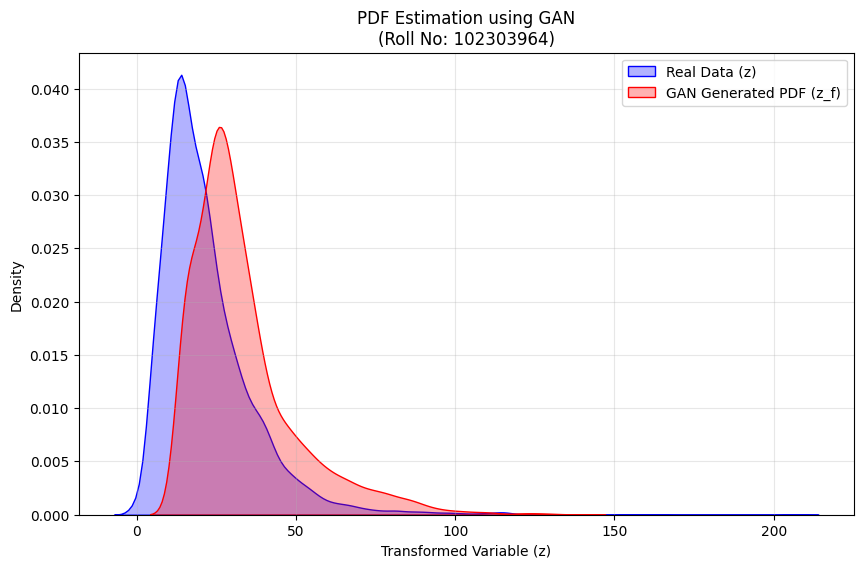

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models, optimizers

ROLL_NUMBER = 102303964

print("1. Loading Data...")
try:
    df = pd.read_csv('/content/data.csv', encoding='cp1252', engine='python')
    print("   Data file loaded.")
except FileNotFoundError:
    print("   Error: 'data.csv' not found. Please upload the file.")
    exit()
except UnicodeDecodeError:
    print("   UnicodeDecodeError. Trying ISO-8859-1 encoding...")
    try:
        df = pd.read_csv('data.csv', encoding='ISO-8859-1', engine='python')
        print("   Data loaded using ISO-8859-1.")
    except Exception as e:
        print(f"   Error loading data with ISO-8859-1 and python engine: {e}")
        print("   Please check the data.csv file for corruption or unexpected characters.")
        exit()
except Exception as e:
    print(f"   An unexpected error occurred during data loading: {e}")
    print("   Please check the data.csv file for corruption or unexpected characters, especially around row 129723.")
    exit()

df['no2'] = pd.to_numeric(df['no2'], errors='coerce')
data_x = df['no2'].dropna().values.astype('float32')

print(f"   Original data count: {len(data_x)}")

if len(data_x) > 10000:
    print(f"   Data is large ({len(data_x)} rows). Subsampling to 10,000 for speed...")
    np.random.seed(42)
    data_x = np.random.choice(data_x, 10000, replace=False)

r = ROLL_NUMBER
a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print(f"2. Transformation Parameters: a_r={a_r}, b_r={b_r}")

data_z = data_x + a_r * np.sin(b_r * data_x)

mean_z = np.mean(data_z)
std_z = np.std(data_z)
data_z_normalized = (data_z - mean_z) / std_z

batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(data_z_normalized)
dataset = dataset.shuffle(buffer_size=2000).batch(batch_size)

def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_dim=1))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    return model

def build_discriminator():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_dim=1))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

generator = build_generator()
discriminator = build_discriminator()

gen_optimizer = optimizers.Adam(learning_rate=0.001)
disc_optimizer = optimizers.Adam(learning_rate=0.001)
cross_entropy = tf.keras.losses.BinaryCrossentropy()

epochs = 1000
latent_dim = 1

@tf.function
def train_step(real_samples):
    batch_size = tf.shape(real_samples)[0]
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_samples = generator(noise, training=True)

        real_output = discriminator(real_samples, training=True)
        fake_output = discriminator(fake_samples, training=True)

        disc_loss_real = cross_entropy(tf.ones_like(real_output), real_output)
        disc_loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = disc_loss_real + disc_loss_fake

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

print("3. Starting training... (Watch for updates below)")

for epoch in range(epochs):
    for batch in dataset:
        g_loss, d_loss = train_step(batch)

    if (epoch + 1) % 50 == 0:
        print(f"   Epoch {epoch+1}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

print("4. Generating Plot...")
num_samples = 5000
noise = tf.random.normal([num_samples, latent_dim])
generated_z_normalized = generator(noise, training=False).numpy()
generated_z_final = (generated_z_normalized * std_z) + mean_z

plt.figure(figsize=(10, 6))
sns.kdeplot(data_z, fill=True, label='Real Data (z)', color='blue', alpha=0.3)
sns.kdeplot(generated_z_final.flatten(), fill=True, label='GAN Generated PDF (z_f)', color='red', alpha=0.3)

plt.title(f'PDF Estimation using GAN\n(Roll No: {ROLL_NUMBER})')
plt.xlabel('Transformed Variable (z)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig('GAN_PDF_Plot.png')
print("   Success! Plot saved as 'GAN_PDF_Plot.png'")
plt.show()